# Regulatory Genomics Lecture Exercise

## Install the dependencies

In addition to the pre-installed packages like numpy, pandas, matplotlib, keras, tensorflow, we'll install concise, a keras extension for regulatory genomics developed in the Gagneur lab: https://github.com/gagneurlab/concise.

In [1]:
! pip install concise

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import concise
from concise.preprocessing import encodeDNA
from concise.utils import PWM

from concise.utils.plot import seqlogo, seqlogo_fig

Using TensorFlow backend.
/opt/modules/i12g/anaconda/3-2018.12/envs/keras/lib/python3.7/site-packages/concise/utils/plot.py:115: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  min_coords = np.vstack(data.min(0) for data in polygons_data).min(0)
/opt/modules/i12g/anaconda/3-2018.12/envs/keras/lib/python3.7/site-packages/concise/utils/plot.py:116: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  max_coords = np.vstack(data.max(0) for data in polygons_data).max(0)
INFO:hyperopt.utils:Failed to load dill, try installing dill via "pip install dill" for enhanced pickling support.
INFO:hyperopt.fmin:Failed to load dill, try installing dill via "pip install dill" 

In [4]:
# Used additional packages
%matplotlib inline

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

# seeding random number generators
seed = 4
np.random.seed(seed)
import tensorflow as tf
tf.set_random_seed(seed)

## Load simulated data

## Get the data

We are going to use simulated data of 10,000 500 bp long sequences with the positive set containing an instance of the TAL1 motif:
![TAL1 known4](http://compbio.mit.edu/encode-motifs/logos/table/logos/small/rev/TAL1_known4.png)
and the negative set will be random sequences. The data were simulated using simDNA https://github.com/kundajelab/simdna by Johnny Israeli and were deposited to https://github.com/kundajelab/dragonn.

In [5]:
!wget 'https://github.com/kundajelab/dragonn/raw/master/paper_supplement/simulation_data/GC_fraction0.4motif_nameTAL1_known4num_neg10000num_pos10000seq_length500.npz'

--2019-06-13 13:57:28--  https://github.com/kundajelab/dragonn/raw/master/paper_supplement/simulation_data/GC_fraction0.4motif_nameTAL1_known4num_neg10000num_pos10000seq_length500.npz
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kundajelab/dragonn/master/paper_supplement/simulation_data/GC_fraction0.4motif_nameTAL1_known4num_neg10000num_pos10000seq_length500.npz [following]
--2019-06-13 13:57:29--  https://raw.githubusercontent.com/kundajelab/dragonn/master/paper_supplement/simulation_data/GC_fraction0.4motif_nameTAL1_known4num_neg10000num_pos10000seq_length500.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6015773 (5.7M) [ap

We now list all files in our directory

In [6]:
ls

DeepBind-solutions.ipynb
GC_fraction0.4motif_nameTAL1_known4num_neg10000num_pos10000seq_length500.npz
GC_fraction0.4motif_nameTAL1_known4num_neg10000num_pos10000seq_length500.npz.1
GC_fraction0.4motif_nameTAL1_known4num_neg10000num_pos10000seq_length500.npz.2
GC_fraction0.4motif_nameTAL1_known4num_neg10000num_pos10000seq_length500.npz.3
GC_fraction0.4motif_nameTAL1_known4num_neg10000num_pos10000seq_length500.npz.4
GC_fraction0.4motif_nameTAL1_known4num_neg10000num_pos10000seq_length500.npz.5
GC_fraction0.4motif_nameTAL1_known4num_neg10000num_pos10000seq_length500.npz.6
GC_fraction0.4motif_nameTAL1_known4num_neg10000num_pos10000seq_length500.npz.7
GC_fraction0.4motif_nameTAL1_known4num_neg10000num_pos10000seq_length500.npz.8
model.png
PWM-solution.ipynb
TAL1_known4.npy
TAL1_known4.npy.1
TAL1_known4.npy.2
TAL1_known4.npy.3
TAL1_known4.npy.4
TAL1_known4.npy.5
TAL1_known4.npy.6


## Load the data
The following function can load the data.

In [7]:
import numpy as np

def load_simulated_data(path):
    """Load the simulated dataset
    
    Args:
      path: path to the .npz file c
    """
    data = np.load(path)

    x_train = data["X_train"].squeeze(1).swapaxes(1,2)
    x_valid = data["X_valid"].squeeze(1).swapaxes(1,2)
    y_train = data['y_train']
    y_valid = data['y_valid']
    return (x_train, y_train), (x_valid, y_valid)

In [8]:
(x_train, y_train), (x_test, y_test) = load_simulated_data("GC_fraction0.4motif_nameTAL1_known4num_neg10000num_pos10000seq_length500.npz")

In [9]:
x_train.shape

(12800, 500, 4)

In [10]:
y_train.shape

(12800, 1)

In [11]:
x_test.shape

(3200, 500, 4)

In [12]:
y_test.shape

(3200, 1)

As you can see, there are 12.8k training examples and 3.2k test examples.

### Visualize the first sequence

The response value is a binary variable:

In [13]:
y_train[:5]

array([[False],
       [False],
       [ True],
       [ True],
       [ True]])

In [14]:
y_train.mean()

0.501953125

In [15]:
y_test.mean()

0.5071875


As the means are close to 0.5, there are balanced classes, i.e. roughly the same number of positive and negative instances. This ratio is the same for training and testing. This is an ideal situation for training a classifier.


The input is the one-hot-encoded DNA sequence:

In [16]:
x_train[0][:10]

array([[0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]], dtype=int8)

In [17]:
from concise.preprocessing.sequence import one_hot2string, DNA

In [18]:
one_hot2string(x_train[:1], DNA)[0]

'CGTTATGAGTCATGACTGTTATTTTTACCCAAAACAGTGTCTAGCCAAAAATATTGATGCAGTGTTTTCATCAGATTCAATTTCCAACGAAAAGACTCGCGTTCCTTAACTGCAAATTAGCGTAATTCTCACTTGCATATCAAGAGTTCTGTACTAAGATCAAACTCAAGTTATTTTAAGGGATACATTTATATAATAACACCCATGAGCCTGAGAAGGTAAGAATCTGACACTAATGATATGCGGTAGCTATTCACTACAGCAATTTAACCTCGAAGGAAAATCCCTTCAACTCACATCTTTTCATGTTATTGCTTTCTGTGATGGCTATGTTTCCGGAATCAGGAAATCGTCTCCTCACTTTCGTGGAGATACATGAACTGGATACGACAAGCGTTGTTATCTCCGATGCCTCAGGCGTGTGCATAATAGCACCGTATTAATTTCTTCAGTATAGTCCAACATGTTTCCGTTGTAGAACCAAAGCGGCTTTTAGATTA'

## Load TAL1 motif Position-specific Weight Matrix (PWM)

Get PWM of TAL1 motif

In [19]:
! wget https://github.com/s6juncheng/SystemGeneticsDL/raw/master/TAL1_known4.npy

--2019-06-13 13:57:30--  https://github.com/s6juncheng/SystemGeneticsDL/raw/master/TAL1_known4.npy
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/s6juncheng/SystemGeneticsDL/master/TAL1_known4.npy [following]
--2019-06-13 13:57:30--  https://raw.githubusercontent.com/s6juncheng/SystemGeneticsDL/master/TAL1_known4.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 640 [application/octet-stream]
Saving to: ‘TAL1_known4.npy.7’

TAL1_known4.npy.7   100%[===================>]     640  --.-KB/s    in 0s      

2019-06-13 13:57:30 (149 MB/s) - ‘TAL1_known4.npy.7’ saved [640/640]



In [20]:
# import cresim
# pwm = cresim.cre.Cre.loadPWM('TAL1_known3').pwm.getRows()

In [21]:
pwm = np.load("TAL1_known4.npy")

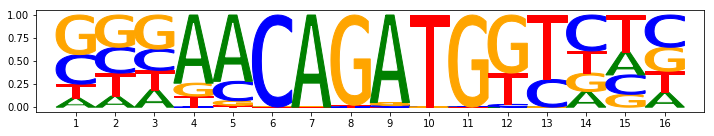

In [22]:
seqlogo_fig(pwm);

## Predict binding with pwm scan model

In this section, you will implement a PWM scan model, which is a convolution operation

In [23]:
# A naiv version
def pwm_scan(sequence, pwm, pad=0, stride=1):
    """ sequence: (N, L, 4)
    output length given by L' = 1 + (L + 2*P - F) / stride
    """
    pwm = np.log(pwm) # transform frequencies into log scale to have an additive model
    assert len(sequence.shape) == 3
    assert pwm.shape[1] == 4
    N, L, _ = sequence.shape
    F, _ = pwm.shape
    S = stride
    assert (L + 2 * pad - F) % S == 0, "Size not fit."
    L_out = int(1 + (L + 2 * pad - F) / S)
    out = np.zeros((N, L_out))

    x_pad = np.pad(sequence, ((0, 0), (1, 1), (0,0)), mode='constant')

    for i in range(N):
        seq = sequence[i]
        for j in range(L_out):
            seq_patch = seq[(j * S):(j * S + F)]
            out[i, j] = np.dot(seq_patch.flatten(), pwm.flatten())

    return out

In [24]:
scores = pwm_scan(x_test, pwm)

In [25]:
scores.shape

(3200, 485)

## Summarize PWM scan ouput per sequence with two pooling strategies

Try two pooling strategies:
  * GloabalAveragePooling: Take average score per sequence 
  * GloabalMaxPooling: take max activation score

### Averange Pooling

In [26]:
mean_scores = scores.mean(axis=1)

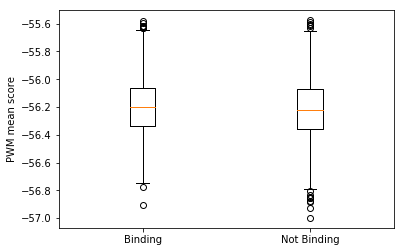

In [27]:
plt.boxplot([mean_scores[y_test.flatten()], mean_scores[~y_test.flatten()]], labels=['Binding','Not Binding'])
plt.ylabel("PWM mean score")
plt.show()

### Max Pooling

In [28]:
max_scores = scores.max(axis=1)

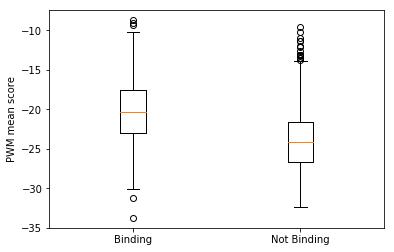

In [29]:
plt.boxplot([max_scores[y_test.flatten()], max_scores[~y_test.flatten()]], labels=['Binding','Not Binding'])
plt.ylabel("PWM mean score")
plt.show()

### Check performance

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score

In [31]:
roc = {}
roc['mean_roc'] = roc_auc_score(y_test, mean_scores)
roc['max_roc'] = roc_auc_score(y_test, max_scores)

In [32]:
fpr = {}
tpr = {}
fpr['Mean'], tpr["Mean"], _ = roc_curve(y_test, mean_scores)
fpr['Max'], tpr["Max"], _ = roc_curve(y_test, max_scores)

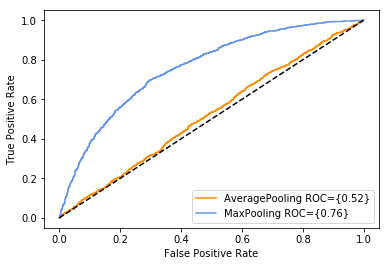

In [33]:
plt.plot(fpr['Mean'], tpr["Mean"], color='darkorange', 
        label = 'AveragePooling ROC={%0.2f}' % roc['mean_roc'])
plt.plot(fpr['Max'], tpr["Max"], color='cornflowerblue', 
        label = 'MaxPooling ROC={%0.2f}' % roc['max_roc'])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

## Build a convolutional neural network

The following code will give you an end-to-end example for training, evaluating and visualizing convolutional neural networks for DNA sequence models.

### Define the model

We'll use Keras (https://keras.io), a popular deep learning library wrapping frameworks like TensorFlow to define and train a neural network. After running the code, go to the documentation and read more about Keras.


https://keras.io/getting-started/sequential-model-guide/

We will now implement a neural network (sketch below) consisting of one convolutional filter whose outputs are  transfomed by the ReLU activation function ($\text{ReLU}(x) = \max(0,x)$). On the resulting vector, we keep the maximal value ("max pooling") giving us a 1-long vector. We then perform a linear transformation of this 1-long vector into a single scalar ("Dense layer") which we map to the $[0,1]$ interval with sigmoid activation function $\text{sigm}(x) = \frac{1}{1+\exp(-x)}$. The interpratation of the output is the probability that the sequence is bound by the transcription factor TAL1.

In [34]:
## required keras modules
from keras.models import Model, load_model, Sequential
import keras.layers as kl
import keras.optimizers as ko

For the convolution operation, we will use  `ConvDNA` from `concise` package. It offers convenient functions to visualize the learned convolution filters.

In [35]:
import concise.layers as cl

In [36]:
# seeding random number generators
seed = 4
np.random.seed(seed)
import tensorflow as tf
tf.set_random_seed(seed)

Model achitecture: ConvDNA (which is Conv1D) --> GlobalMaxPooling1D  -->  Dense --> Sigmoid

In [37]:
model = Sequential()
# Add one convolution layer, Conv1D
model.add(cl.ConvDNA(filters=1,
                    kernel_size=15,
                    activation='relu',
                    input_shape=(500, 4), # shape: Length sequence, 4nt
                    name='convDNA'))
model.add(kl.GlobalMaxPooling1D())
model.add(kl.Dense(1, name='dense'))
model.add(kl.Activation('sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convDNA (ConvDNA)            (None, 486, 1)            61        
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 1)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 63
Trainable params: 63
Non-trainable params: 0
_________________________________________________________________


The following image shows the initial weights:

<Figure size 1440x216 with 0 Axes>

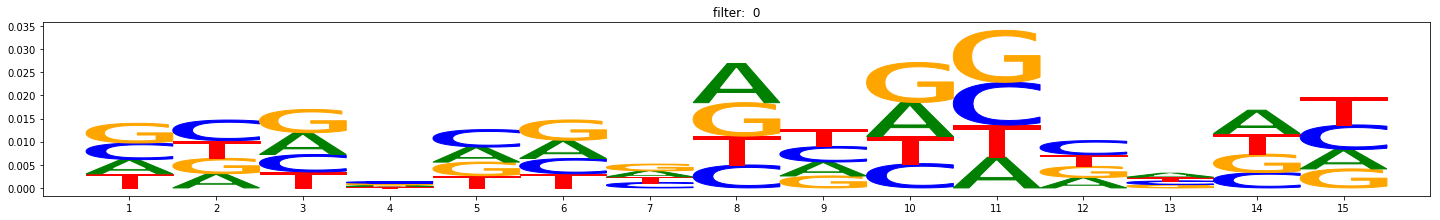

In [39]:
model.layers[0].plot_weights(figsize=(20, 3), plot_type="motif_pwm_info");

### Train the model

In [40]:
from keras import optimizers

model.compile(optimizer=optimizers.Adam(lr=0.05), loss="binary_crossentropy")

from keras.callbacks import EarlyStopping

model.fit(x=x_train, y=y_train, epochs=300, verbose=2,
          callbacks=[
              EarlyStopping(patience=5)
          ],
          validation_split=.2
         )

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Train on 10240 samples, validate on 2560 samples
Epoch 1/300
 - 1s - loss: 0.3310 - val_loss: 0.2946
Epoch 2/300
 - 1s - loss: 0.2498 - val_loss: 0.2594
Epoch 3/300
 - 1s - loss: 0.2435 - val_loss: 0.2621
Epoch 4/300
 - 1s - loss: 0.2430 - val_loss: 0.2582
Epoch 5/300
 - 1s - loss: 0.2411 - val_loss: 0.2566
Epoch 6/300
 - 1s - loss: 0.2393 - val_loss: 0.2505
Epoch 7/300
 - 1s - loss: 0.2396 - val_loss: 0.2557
Epoch 8/300
 - 1s - loss: 0.2384 - val_loss: 0.2500
Epoch 9/300
 - 1s - loss: 0.2359 - val_loss: 0.2507
Epoch 10/300
 - 1s - loss: 0.2382 - val_loss: 0.2509
Epoch 11/300
 - 1s - loss: 0.2403 - val_loss: 0.3090
Epoch 12/300
 - 1s - loss: 0.2357 - val_loss: 0.2529
Epoch 13/300
 - 1s - loss: 0.2382 - val_loss: 0.2452
Epoch 14/300
 - 1s - loss: 0.2394 - val_loss: 0.2588
Epoch 15/300
 - 1s - loss: 0.2375 - val_loss: 0.2654
Epoch 16/300
 - 1s - loss: 0.2402 - val_loss: 0.2850
Epoch 17/300
 - 1s - loss: 0.2368 - val_loss: 0.2520
Epoch 18/300
 - 1s - loss: 0.2356 - val_loss: 0.2471


In [41]:
model.layers[0]

<Figure size 1440x216 with 0 Axes>

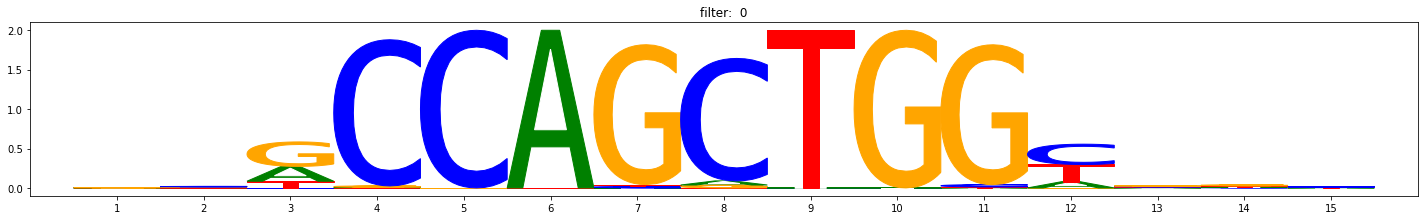

In [42]:
model.layers[0].plot_weights(figsize=(20, 3), plot_type="motif_pwm_info");

In [43]:
y_test_pred = model.predict(x_test)

roc['ConvNet1Motif'] = roc_auc_score(y_test, y_test_pred)

In [44]:
fpr['ConvNet1Motif'], tpr["ConvNet1Motif"], _ = roc_curve(y_test, y_test_pred)

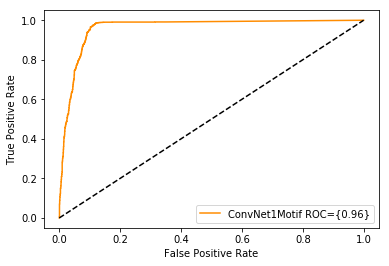

In [45]:
plt.plot(fpr['ConvNet1Motif'], tpr["ConvNet1Motif"], color='darkorange', 
        label = 'ConvNet1Motif ROC={%0.2f}' % roc['ConvNet1Motif'])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

### Build a model with 4 filters

In [46]:
# seeding random number generators
seed = 4
np.random.seed(seed)
import tensorflow as tf
tf.set_random_seed(seed)

We will now implement a neural network (sketch below) consisting of 4 convolutional filters whose outputs are transfomed by the ReLU activation function ($\text{ReLU}(x) = \max(0,x)$). On each of the 4 resulting vectors, we keep the maximal value ("max pooling") giving a us 4-long vector. We then perform a linear transformation of this 4-long vector into a single scalar ("Dense layer") which we map to the $[0,1]$ interval with sigmoid activation function $\text{sigm}(x) = \frac{1}{1+\exp(-x)} $ . The interpratation of the output is the probability that the sequence is bound by the transcription factor TAL1.

In [47]:
model = Sequential()
# Add one convolution layer, Conv1D
model.add(cl.ConvDNA(filters=4,
                    kernel_size=15,
                    activation='relu',
                    input_shape=(500, 4), # shape: Length sequence, 4nt
                    name='convDNA'))
model.add(kl.GlobalMaxPooling1D())
model.add(kl.Dense(1, name='dense'))
model.add(kl.Activation('sigmoid'))

In [48]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convDNA (ConvDNA)            (None, 486, 4)            244       
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 4)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 249
Trainable params: 249
Non-trainable params: 0
_________________________________________________________________


In [49]:
from keras import optimizers

model.compile(optimizer=optimizers.Adam(lr=0.05), loss="binary_crossentropy")

from keras.callbacks import EarlyStopping

model.fit(x=x_train, y=y_train, epochs=300, verbose=2,
          callbacks=[
              EarlyStopping(patience=5)
          ],
          validation_split=.2
         )

Train on 10240 samples, validate on 2560 samples
Epoch 1/300
 - 2s - loss: 0.3689 - val_loss: 0.3096
Epoch 2/300
 - 1s - loss: 0.2588 - val_loss: 0.2703
Epoch 3/300
 - 1s - loss: 0.2562 - val_loss: 0.2592
Epoch 4/300
 - 1s - loss: 0.2443 - val_loss: 0.2954
Epoch 5/300
 - 1s - loss: 0.2502 - val_loss: 0.2493
Epoch 6/300
 - 1s - loss: 0.2438 - val_loss: 0.2558
Epoch 7/300
 - 1s - loss: 0.2415 - val_loss: 0.2549
Epoch 8/300
 - 1s - loss: 0.2366 - val_loss: 0.2513
Epoch 9/300
 - 1s - loss: 0.2328 - val_loss: 0.2520
Epoch 10/300
 - 1s - loss: 0.2361 - val_loss: 0.2532


<Figure size 1440x864 with 0 Axes>

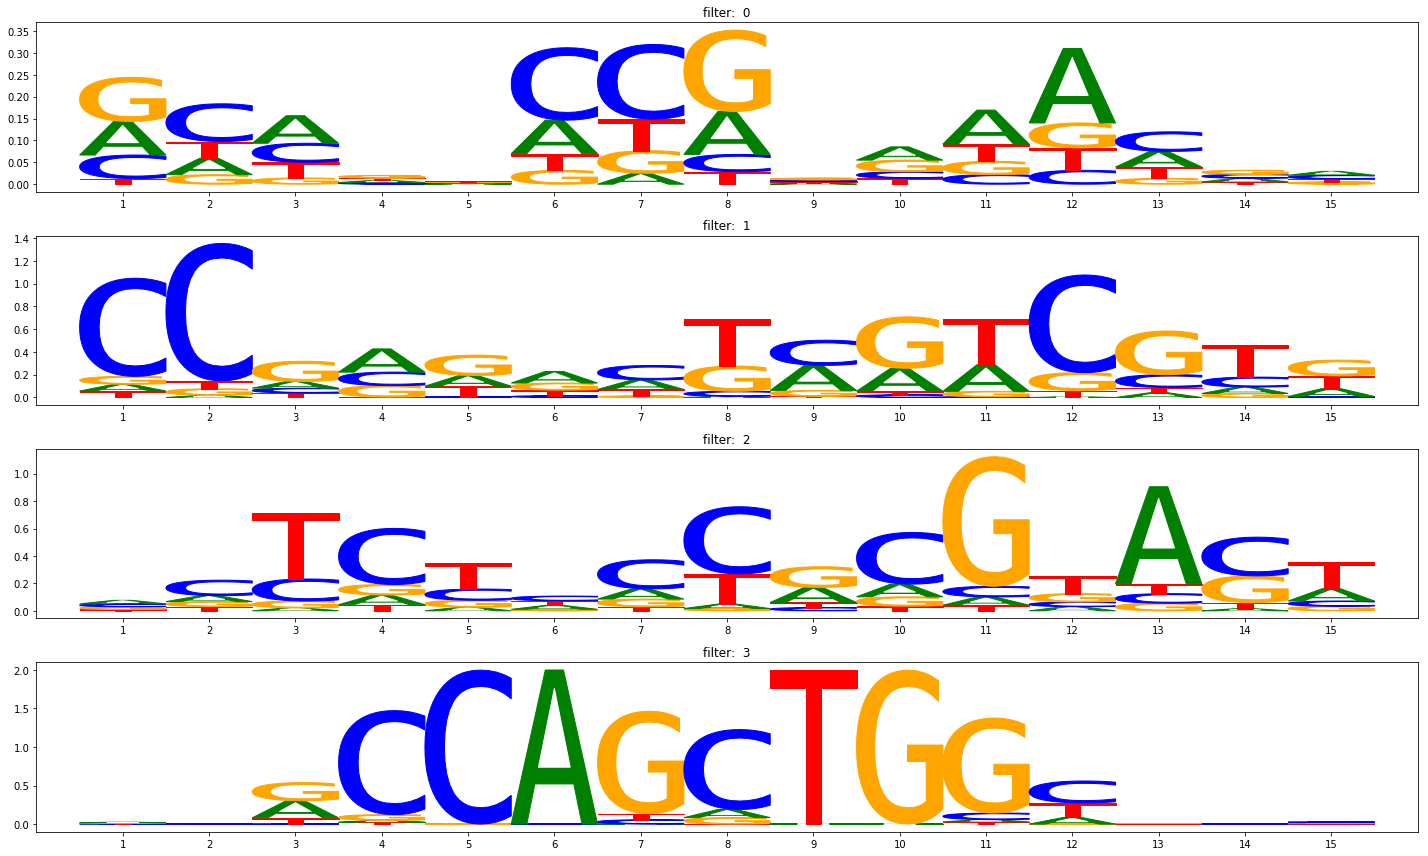

In [50]:
model.layers[0].plot_weights(figsize=(20, 12), plot_type="motif_pwm_info");

In [51]:
y_test_pred = model.predict(x_test)

roc['ConvNet16Motif'] = roc_auc_score(y_test, y_test_pred)

In [52]:
fpr['ConvNet16Motif'], tpr["ConvNet16Motif"], _ = roc_curve(y_test, y_test_pred)

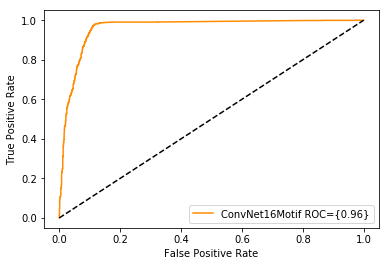

In [53]:
plt.plot(fpr['ConvNet16Motif'], tpr["ConvNet16Motif"], color='darkorange', 
        label = 'ConvNet16Motif ROC={%0.2f}' % roc['ConvNet16Motif'])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()